## 🌐 **Google Drive Connection**

In [2]:
# Install and configure Kaggle API
!pip install -q kaggle

from google.colab import files
print("Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)")
files.upload()  # kaggle.json

# Configura le credenziali
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Monta Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

# Percorso di destinazione sul Drive
dataset_path = "/content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
!mkdir -p {dataset_path}

# Scarica il dataset direttamente da Kaggle nella cartella scelta
!kaggle competitions download -c an2dl2526c1 -p {dataset_path}

# Decomprimi (opzionale, solo se i file sono .zip)
!unzip -o {dataset_path}/an2dl2526c1.zip -d {dataset_path}

print(f"Dataset scaricato e disponibile in: {dataset_path}")


Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)


Saving kaggle.json to kaggle.json
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
an2dl2526c1.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/an2dl2526c1.zip
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_test.csv  
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train.csv  
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train_labels.csv  
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/sample_submission.csv  
Dataset scaricato e disponibile in: /content/gdrive/MyDrive/Artificial_Neural_Net

## ⚙️ **Libraries Import**

In [3]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Profiling library
!pip install -U ydata-profiling
from ydata_profiling import ProfileReport

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [4]:
dataset_path = "/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
os.makedirs(dataset_path, exist_ok=True)

competition = "an2dl2526c1"
# file needed
dataset_files = ["pirate_pain_test.csv", "pirate_pain_train.csv", "pirate_pain_train_labels.csv"]

# Download file if not done yet
for fname in dataset_files:
    dest_path = os.path.join(dataset_path, fname)
    if not os.path.exists(dest_path):
        print(f"📥 Downloading {fname} ...")
        !kaggle competitions download -c {competition} -f {fname} -p {dataset_path}
    else:
        print(f"✅ {fname} already exists. Using cached version.")

print("\nAll files ready in:", dataset_path)


📥 Downloading pirate_pain_test.csv ...
  0% 0.00/125M [00:00<?, ?B/s]
100% 125M/125M [00:00<00:00, 1.57GB/s]
📥 Downloading pirate_pain_train.csv ...
  0% 0.00/60.8M [00:00<?, ?B/s]
100% 60.8M/60.8M [00:00<00:00, 1.39GB/s]
📥 Downloading pirate_pain_train_labels.csv ...
  0% 0.00/7.97k [00:00<?, ?B/s]
100% 7.97k/7.97k [00:00<00:00, 33.9MB/s]

All files ready in: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset


In [5]:
df_training = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train.csv"))
df_labels = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train_labels.csv"))
df_test = pd.read_csv(os.path.join(dataset_path, "pirate_pain_test.csv"))

# create a single dataset with the labels associated
df_training = df_training.merge(df_labels, on='sample_index', how='left')

## 🔎 **Data exploration**

In [6]:
data_profile = ProfileReport(df_training, title="Profiling Report")
data_profile

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# @title Data type conversions
# Convert joint columns
joint_cols = [col for col in df_training.columns if col.startswith("joint_")]
for col in joint_cols:
    df_training[col] = pd.to_numeric(df_training[col], errors='coerce').astype('float32')

# Convert survey values
survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
for col in survey_cols:
    df_training[col] = pd.to_numeric(df_training[col], errors='coerce').astype('int8')

# Creation of unique injury related feature
df_training['is_injured'] = (df_training['n_legs'] != 'two').astype('int8')

# Drop columns
cols_to_drop = [
    'joint_30',   #constant
    'n_eyes', 'n_hands', 'n_legs' #redundant
]
df_training = df_training.drop(columns=[c for c in cols_to_drop if c in df_training.columns])

#df_training.info()

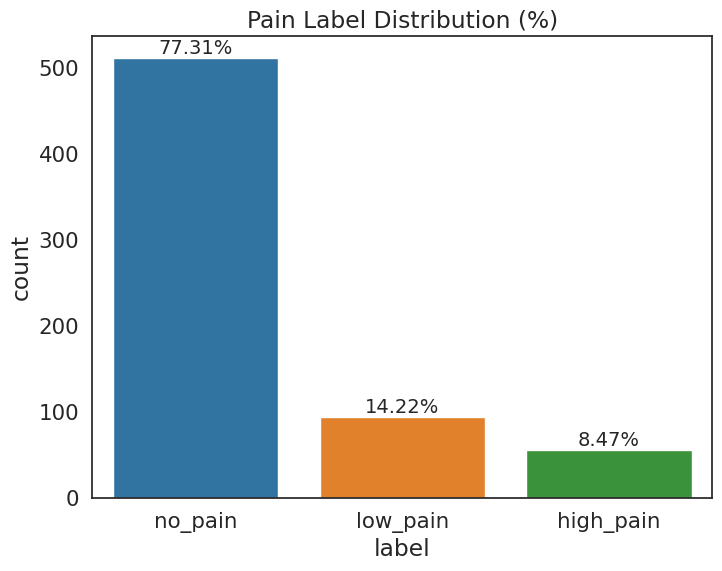

In [8]:
# @title Class distribution
plt.figure(figsize=(8,6))
sns.countplot(
    data=df_labels,
    x='label',
    order=df_labels['label'].value_counts().index,
    palette='tab10'
)

counts = df_labels['label'].value_counts()
perc = (counts / len(df_labels) * 100).round(2)

for i, (cls, pct) in enumerate(perc.items()):
    plt.text(i, counts[i], f"{pct}%", ha='center', va='bottom')

plt.title("Pain Label Distribution (%)")
plt.show()


****

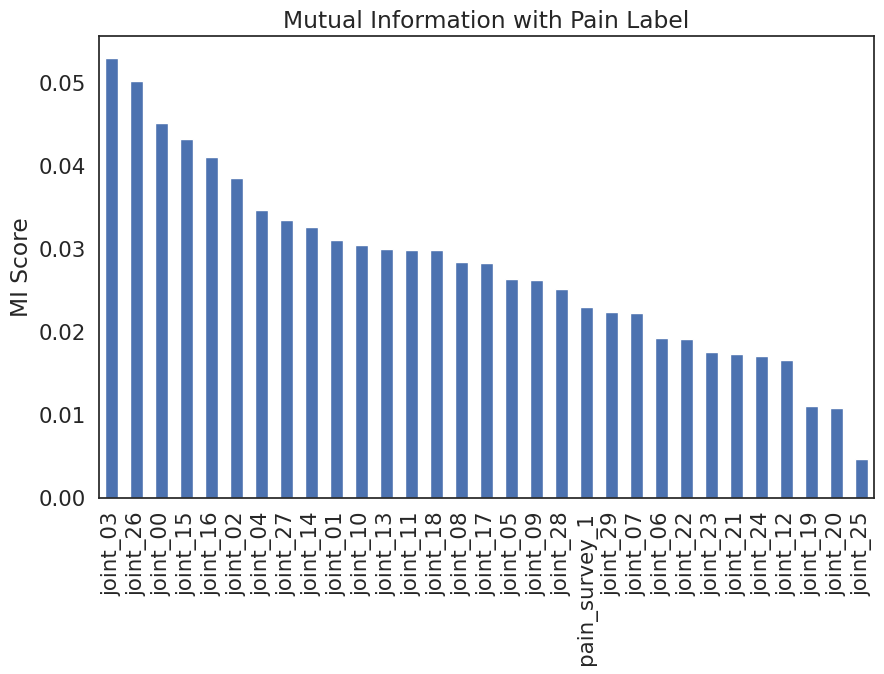

In [9]:
#@title Mutual Information with pain Label

df_mi = df_training.copy()
df_mi['label'] = df_mi['label'].astype('category').cat.codes

joint_cols = [col for col in df_training.columns if col.startswith("joint_")]
survey_cols = ['pain_survey_1']#['pain_survey_1','pain_survey_2','pain_survey_3','pain_survey_4']
#injury_cols = ['is_injured']
X = df_mi[joint_cols + survey_cols ] #+ injury_cols]
y = df_mi['label']

mi_scores = mutual_info_classif(X, y, random_state=0)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
mi_series.plot(kind='bar')
plt.title("Mutual Information with Pain Label")
plt.ylabel("MI Score")
plt.show()


**Outliers detection**

In [10]:
#@title Plot joints mean over time
# Select joint features
joint_cols = [col for col in df_training.columns if col.startswith("joint_")]
joint_cols = sorted(joint_cols, key=lambda x: int(x.split("_")[1]))

# Ensure time is sorted
df_sorted = df_training.sort_values("time")

# Classes present
classes = ['no_pain', 'low_pain', 'high_pain']
colors = ['blue', 'orange', 'green']

# Loop through all joint features
for (i,col) in enumerate(joint_cols):
    plt.figure(figsize=(12, 4))

    for cls, color in zip(classes, colors):
        # Select only rows of this class
        df_cls = df_sorted[df_sorted['label'] == cls]

        # Compute mean aggregation by time
        mean_ts = df_cls.groupby("time")[col].mean()

        plt.plot(mean_ts.index, mean_ts.values, label=cls, color=color)

    plt.title(f"Time progression mean per class — {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"/content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/media_plot{i}.png", dpi=300, bbox_inches="tight")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

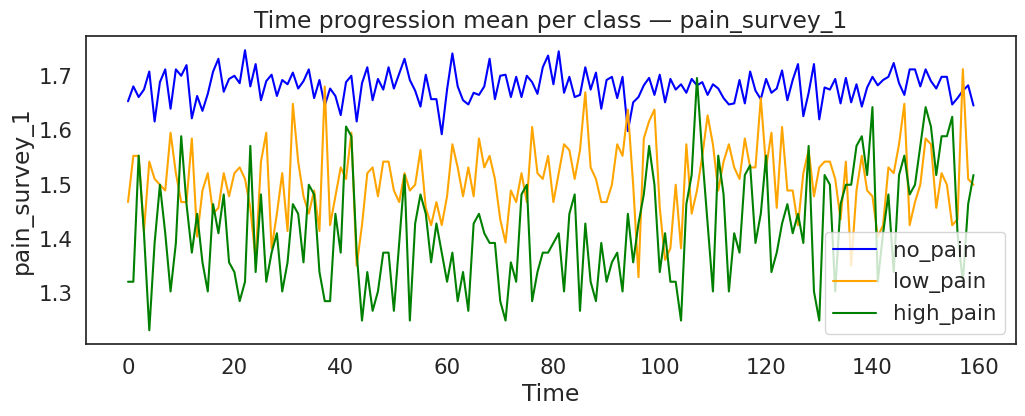

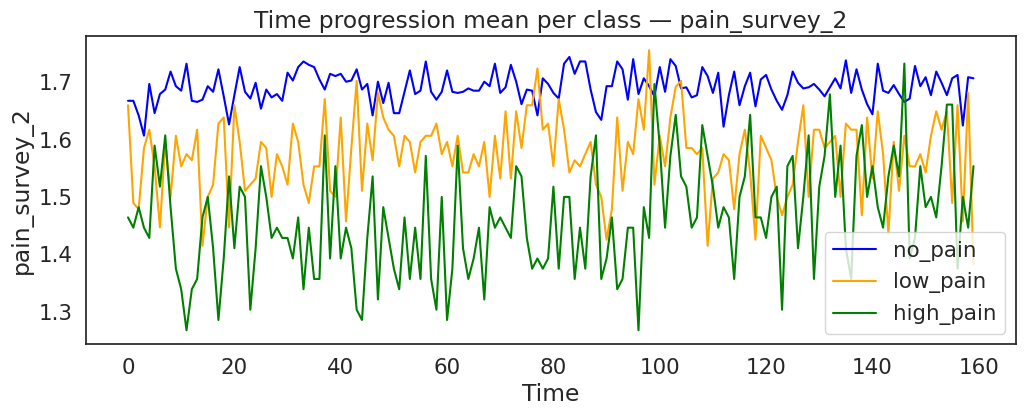

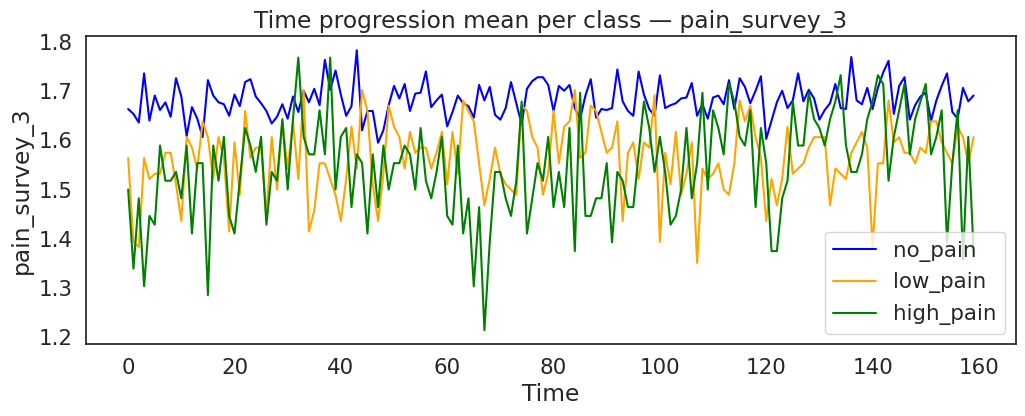

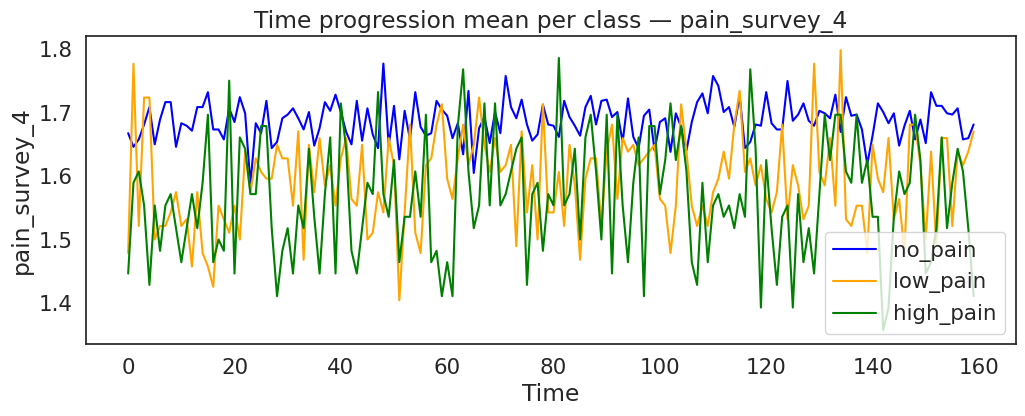

In [11]:
# @title Plot surveys mean over time
# Select survey features
survey_cols = [col for col in df_training.columns if col.startswith("pain_survey_")]

# Ensure time ordering
df_sorted = df_training.sort_values("time")

# Labels and colors
classes = ['no_pain', 'low_pain', 'high_pain']
colors = ['blue', 'orange', 'green']

# Loop over surveys
for col in survey_cols:
    plt.figure(figsize=(12, 4))

    for cls, color in zip(classes, colors):
        df_cls = df_sorted[df_sorted['label'] == cls]

        # Compute mean per time
        mean_ts = df_cls.groupby("time")[col].mean()

        plt.plot(mean_ts.index, mean_ts.values, label=cls, color=color)

    plt.title(f"Time progression mean per class — {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.legend()
    plt.show()

In [12]:
# Label mapping
label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
df_training['label'] = df_training['label'].map(label_mapping)

# df_training.info()

#🧽 **Data cleaning and normalization**

In [13]:
def minmax_scaling(df, min_train=None, max_train=None):
    survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
    joint_cols = [c for c in df.columns if c.startswith("joint_")]
    continuous_cols = survey_cols + joint_cols

    df_scaled = df.copy()

    # Caso TRAINING: calcola min/max
    if min_train is None or max_train is None:
        min_train = df[continuous_cols].min()
        max_train = df[continuous_cols].max()

    # Evita divisione per zero
    ranges = (max_train - min_train).replace(0, 1)

    # Scaling
    df_scaled[continuous_cols] = (df_scaled[continuous_cols] - min_train) / ranges

    return df_scaled


In [14]:
#  @title Robust scaler
from sklearn.preprocessing import RobustScaler
def robust_scaler(df_train: pd.DataFrame, df_val: pd.DataFrame, features):
  df_train_scaled = df_train.copy()
  df_val_scaled = df_val.copy()
  scaler = RobustScaler()
  df_train_scaled[features] = scaler.fit_transform(df_train[features])
  df_val_scaled[features] = scaler.transform(df_val[features])
  return df_train_scaled, df_val_scaled

In [15]:
# @title Clip + Log
# This function is used to change the shape of the distribution

def clip_log(df_train, df_val, features):
    """
    Applica il Clipping (1%-99% quantile) e la trasformazione Log(1+x)
    alle feature con alta asimmetria (skewness), basando le statistiche solo sul training set.
    """

    df_train_scaled = df_train.copy()
    df_val_scaled = df_val.copy()
    normal_cols = []
    transformable_cols = []
    extreme_cols = []
    train_stats = {}

    # 1. Calcolo delle statistiche di trasformazione solo sul TRAINING set
    for col in features:
        # Calcolo dell'asimmetria (skew)
        s = skew(df_train_scaled[col].dropna())

        # Calcolo dei quantili per il clipping
        q_low = df_train_scaled[col].quantile(0.01)
        q_high = df_train_scaled[col].quantile(0.99)

        train_stats[col] = {'skew': s, 'q_low': q_low, 'q_high': q_high, 'min': df_train_scaled[col].min()}

        # Classificazione delle colonne in base all'asimmetria
        if abs(s) < 2:
            normal_cols.append(col)
        elif 2 <= abs(s) <= 10:
            transformable_cols.append(col)
        else:
            extreme_cols.append(col)

    # 2. Applicazione di Clipping e Log-transform (sia su Train che su Validation)
    cols_to_transform = transformable_cols + extreme_cols
    print(f"Trasformazione applicata a: {cols_to_transform}")

    for col in cols_to_transform:
        stats = train_stats[col]
        m = stats['min']
        q_low = stats['q_low']
        q_high = stats['q_high']

        # Trasformazione del Training Set
        df_train_scaled[col] = df_train_scaled[col].clip(q_low, q_high)
        df_train_scaled[col] = np.log1p(df_train_scaled[col] - m + 1e-6)

        # Trasformazione del Validation Set (usando le statistiche del Train)
        if col in df_val_scaled.columns:
            df_val_scaled[col] = df_val_scaled[col].clip(q_low, q_high)
            df_val_scaled[col] = np.log1p(df_val_scaled[col] - m + 1e-6)

        # Test
        # if col in df_test.columns:
        #     df_test[col] = df_test[col].clip(q_low, q_high)
        #     df_test[col] = np.log1p(df_test[col] - m + 1e-6)

    return df_train_scaled, df_val_scaled

#⚙️ **Hyperparameters**

In [16]:
# # ============================================
# # Architecture
# # ============================================
RNN_TYPE = 'GRU'
BIDIRECTIONAL = True
HIDDEN_LAYERS = 1
HIDDEN_SIZE = 128
DROPOUT_RATE = 0.4


# # ============================================
# # Testa MLP
# # ============================================
# MLP_HIDDEN = [128]
# MLP_DROPOUT = [0.3]


# # ============================================
# # Training
# # ============================================
BATCH_SIZE = 64
EPOCHS = 400
PATIENCE = 50
LEARNING_RATE = 5e-4
VERBOSE = 10


# # ============================================
# # Regularization
# # ============================================
L1_LAMBDA = 0.00
L2_LAMBDA = 0.001

T_NO_PAIN = 0.63
T_LOW_PAIN = 0.45
T_HIGH_PAIN = 0.40

# # ============================================
# # Windowing
# # ============================================
WINDOW_SIZE = 20
STRIDE = 10

# # ============================================
# # Undersampling
# # ============================================
TARGET_NO_PAIN = 350

# # ============================================
# # Cross-validation
# # ============================================
K = 2
N_VAL_USERS = round(0.2 * (len(df_training['sample_index'].unique())))
N_TEST_USERS = 0

In [17]:
def compute_class_weights(df, label_col="label"):
    class_counts = df[label_col].value_counts().sort_index().values
    w = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float32))
    w[2] *= 1.5   # boost per high_pain
    return w


#➗ **Train-Validation split**

In [18]:
from sklearn.model_selection import train_test_split

# Pirate-wise splitting
df_subjects = (
    df_training[['sample_index', 'label']]
    .drop_duplicates(subset=['sample_index'])
)

# Stratified Train/Validation split
train_subjects, val_subjects = train_test_split(
    df_subjects['sample_index'],
    test_size=0.2,
    random_state=SEED,
    stratify=df_subjects['label']
)

# Dataset split
df_train = df_training[df_training['sample_index'].isin(train_subjects)].copy()
df_val = df_training[df_training['sample_index'].isin(val_subjects)].copy()

In [19]:
# # @title Undersampling
# #Pirates by class
# train_pirates = (
#     df_train[['sample_index', 'label']]
#     .drop_duplicates()
# )

# print("Pirates per class:")
# print(train_pirates['label'].value_counts())

# # Undersampling no_pain pirates
# no_pain_ids = train_pirates[train_pirates['label'] == 0]['sample_index'].values
# other_ids   = train_pirates[train_pirates['label'] != 0]['sample_index'].values

# if len(no_pain_ids) > TARGET_NO_PAIN:
#     kept_no_pain_ids = np.random.choice(
#         no_pain_ids,
#         size=TARGET_NO_PAIN,
#         replace=False
#     )
# else:
#     kept_no_pain_ids = no_pain_ids

# # no_pain pirates to keep
# kept_ids = np.concatenate([kept_no_pain_ids, other_ids])

# # Smaller df_train
# df_train = df_train[df_train['sample_index'].isin(kept_ids)].reset_index(drop=True)

# print("\nPirates per class (after undersampling):")
# print(
#     df_train[['sample_index', 'label']]
#     .drop_duplicates()['label']
#     .value_counts()
# )


In [20]:
# Continuous columns (serve per min/max)
survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
joint_cols = [c for c in df_training.columns if c.startswith("joint_")]
continuous_cols = survey_cols + joint_cols

min_train = df_train[continuous_cols].min()
max_train = df_train[continuous_cols].max()

df_train = minmax_scaling(df_train, min_train, max_train)
df_val   = minmax_scaling(df_val,   min_train, max_train)


# Fill NaN
df_train = df_train.fillna(0.0)
df_val   = df_val.fillna(0.0)

# Weighted loss
class_weights = compute_class_weights(df_train)


#🪟 **Sequence building**

In [21]:
# joint_cols = [c for c in df_train.columns if c.startswith("joint_")]
# survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
# feature_cols = joint_cols + survey_cols + ["is_injured"]

# === 1) LISTA DELLE FEATURE SCELTE ===
selected_features = [
    "joint_00", "joint_01",
    "joint_02", "joint_03",
    "joint_04", "joint_05",
    "joint_06",
    "joint_07",
    "joint_08", "joint_09",
    "joint_10", "joint_11",
    "joint_12",
    #"joint_13",
    #"joint_14",
    #"joint_15",
    "joint_16",
    #"joint_17",
    #"joint_18",
    "joint_19",
    "joint_20",
    "joint_21",
    #"joint_22",
    "joint_23",
    #"joint_24",
    "joint_25",
    "joint_26",
    "joint_27",
    "joint_28",
    "joint_29",

    "pain_survey_1",
    #"pain_survey_2",
    #"pain_survey_3",
    #"pain_survey_4"
]

feature_cols = selected_features

def build_windows(df, window=40, stride=20):

    df = df.copy()

    # for col in survey_cols:
    #     if df[col].dtype.name == "category":
    #         df[col] = df[col].cat.codes

    # if df["is_injured"].dtype.name == "category":
    #     df["is_injured"] = df["is_injured"].cat.codes

    # assert window % stride == 0

    X_windows = []
    y_windows = []

    for sid, group in df.groupby('sample_index'):

        # Sort by time series order
        group = group.sort_values("time")

        # Extract features
        X = group[feature_cols].values.astype('float32')

        # Label per pirate
        y = group['label'].iloc[0]

        # Padding
        padding_len = (window - len(X) % window) % window
        if padding_len > 0:
            X = np.concatenate(
                [X, np.zeros((padding_len, X.shape[1]), dtype='float32')]
            )

        # Generate windows
        for start in range(0, len(X) - window + 1, stride):
            X_windows.append(X[start:start+window])
            y_windows.append(y)

    return np.array(X_windows, dtype=np.float32), np.array(y_windows, dtype=np.int64)


In [22]:
# Build windows
X_train, y_train = build_windows(df_train, WINDOW_SIZE, STRIDE)
X_val, y_val = build_windows(df_val, WINDOW_SIZE, STRIDE)

# === OVERSAMPLING HIHG PAIN ===#

# # Oversampling high_pain
# high_class = 2
# X_high = X_train[y_train == high_class]
# y_high = y_train[y_train == high_class]

# X_train = np.concatenate([X_train] + [X_high] * REPEAT, axis=0)
# y_train = np.concatenate([y_train] + [y_high] * REPEAT, axis=0)

# # #Shuffle after oversampling
# shuffle_idx = np.random.permutation(len(X_train))
# X_train = X_train[shuffle_idx]
# y_train = y_train[shuffle_idx]

# === OVERSAMPLING HIHG PAIN ===#

# Print the shapes of the generated datasets and their labels
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)

# Define input shape for the RNN
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

X_train: (7920, 20, 24) y_train: (7920,)
X_val:   (1995, 20, 24) y_val:   (1995,)


In [23]:
# Convert to PyTorch datasets
train_ds = TensorDataset(
    torch.from_numpy(X_train),
    torch.from_numpy(y_train)
)

val_ds = TensorDataset(
    torch.from_numpy(X_val),
    torch.from_numpy(y_val)
)

In [24]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [25]:
train_loader = make_loader(train_ds, BATCH_SIZE, True,  False)
val_loader   = make_loader(val_ds,   BATCH_SIZE, False, False)

In [26]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([64, 20, 24])
Labels batch shape: torch.Size([64])


# 🛠️ **Model Building**

In [27]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [28]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

        # ===== HEAD MLP PARAMETRICA =====
        # layers = []
        # in_dim = classifier_input_size

        # for hdim, dr in zip(MLP_HIDDEN, MLP_DROPOUT):
        #     layers.append(nn.Linear(in_dim, hdim))
        #     layers.append(nn.ReLU())
        #     layers.append(nn.Dropout(dr))
        #     in_dim = hdim

        # # ultimo layer verso le classi
        # layers.append(nn.Linear(in_dim, num_classes))

        # self.classifier = nn.Sequential(*layers)
        # =================================



    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 **Model Training**

In [30]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [31]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [32]:
import torch.nn.functional as F

def threshold_predict(logits,
                      t_no_pain=T_NO_PAIN,
                      t_low_pain=T_LOW_PAIN,
                      t_high_pain=T_HIGH_PAIN):
    """
    logits: tensor (batch, 3)
    Ritorna: predizioni (tensor) shape (batch,)
    """

    probs = F.softmax(logits, dim=1)

    NO = 0
    LOW = 1
    HIGH = 2

    preds = []

    for p in probs:
        if p[NO] >= t_no_pain:
            preds.append(NO)
            continue
        if p[LOW] >= t_low_pain:
            preds.append(LOW)
            continue
        if p[HIGH] >= t_high_pain:
            preds.append(HIGH)
            continue

        preds.append(torch.argmax(p).item())

    return torch.tensor(preds)


In [33]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)

            #===THRESHOLD===#
            #predictions = logits.argmax(dim=1)
            predictions = threshold_predict(logits)
            #===THRESHOLD===#

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [34]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [35]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [36]:
def fit_final(model, train_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the full dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [],
        'train_f1': [],
    }

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['train_f1'].append(train_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, model)

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | ")

        # Close TensorBoard writer
        if writer is not None:
            writer.close()

    return model, training_history

#⚠️ **MODEL**

In [37]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=len(feature_cols),
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "rnn"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)


# ----------------------------
# OPTIMIZER & MIXED PRECISION
# ----------------------------

# Define optimizer
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
#criterion = nn.CrossEntropyLoss()

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 20, 256], [2, -1, 128]] 118,272        
classifier (Linear)       [-1, 3]                      771            
Total params: 119,043
Trainable params: 119,043
Non-trainable params: 0
-------------------------------------------------------------------------------


In [38]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=10,
    experiment_name="rnn",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 400 epochs...
Epoch   1/400 | Train: Loss=0.9601, F1 Score=0.7149 | Val: Loss=0.8532, F1 Score=0.7132
Epoch  10/400 | Train: Loss=0.4226, F1 Score=0.8899 | Val: Loss=0.6263, F1 Score=0.8234
Epoch  20/400 | Train: Loss=0.2544, F1 Score=0.9311 | Val: Loss=0.5962, F1 Score=0.8563
Epoch  30/400 | Train: Loss=0.1876, F1 Score=0.9461 | Val: Loss=0.6096, F1 Score=0.8803
Epoch  40/400 | Train: Loss=0.1416, F1 Score=0.9559 | Val: Loss=0.5763, F1 Score=0.8698
Epoch  50/400 | Train: Loss=0.1165, F1 Score=0.9603 | Val: Loss=0.5091, F1 Score=0.8874
Epoch  60/400 | Train: Loss=0.0914, F1 Score=0.9697 | Val: Loss=0.5956, F1 Score=0.9034
Epoch  70/400 | Train: Loss=0.0876, F1 Score=0.9705 | Val: Loss=0.5922, F1 Score=0.9048
Epoch  80/400 | Train: Loss=0.0748, F1 Score=0.9756 | Val: Loss=1.0148, F1 Score=0.8379
Epoch  90/400 | Train: Loss=0.0771, F1 Score=0.9744 | Val: Loss=0.5521, F1 Score=0.9165
Epoch 100/400 | Train: Loss=0.0562, F1 Score=0.9826 | Val: Loss=0.9754, F1 Score=0.8351
Epoch 110

#📈 **Results**

In [39]:
def evaluate_final(model, val_loader, device):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(xb)

            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

    # Concatenate all batches
    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)

    # Compute metrics
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_per_class = f1_score(y_true, y_pred, average=None)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # FP and FN
    FP = cm.sum(axis=0) - np.diag(cm)   # predetti come classe i ma non erano classe i
    FN = cm.sum(axis=1) - np.diag(cm)   # erano classe i ma predetti altra classe

    print("=== FINAL VALIDATION PERFORMANCE ===")
    print(f"F1 Weighted: {f1_weighted:.4f}")
    print(f"F1 Macro:    {f1_macro:.4f}")
    print(f"F1 Per Class (0=no_pain, 1=low_pain, 2=high_pain): {f1_per_class}")

    print("\nConfusion Matrix:")
    print(cm)

    print("\nFalse Positives per class:")
    print(f"0=no_pain:   {FP[0]}")
    print(f"1=low_pain:  {FP[1]}")
    print(f"2=high_pain: {FP[2]}")

    print("\nFalse Negatives per class:")
    print(f"0=no_pain:   {FN[0]}")
    print(f"1=low_pain:  {FN[1]}")
    print(f"2=high_pain: {FN[2]}")

    return f1_weighted, f1_macro, f1_per_class, cm, FP, FN

evaluate_final(rnn_model, val_loader, device)

=== FINAL VALIDATION PERFORMANCE ===
F1 Weighted: 0.9196
F1 Macro:    0.8277
F1 Per Class (0=no_pain, 1=low_pain, 2=high_pain): [0.95666235 0.87241379 0.65408805]

Confusion Matrix:
[[1479   41   25]
 [   8  253   24]
 [  60    1  104]]

False Positives per class:
0=no_pain:   68
1=low_pain:  42
2=high_pain: 49

False Negatives per class:
0=no_pain:   66
1=low_pain:  32
2=high_pain: 61


(0.9196019032490759,
 0.8277213992936815,
 array([0.95666235, 0.87241379, 0.65408805]),
 array([[1479,   41,   25],
        [   8,  253,   24],
        [  60,    1,  104]]),
 array([68, 42, 49]),
 array([66, 32, 61]))

Accuracy over the validation set: 0.9203
Precision over the validation set: 0.9191
Recall over the validation set: 0.9203
F1 score over the validation set: 0.9196


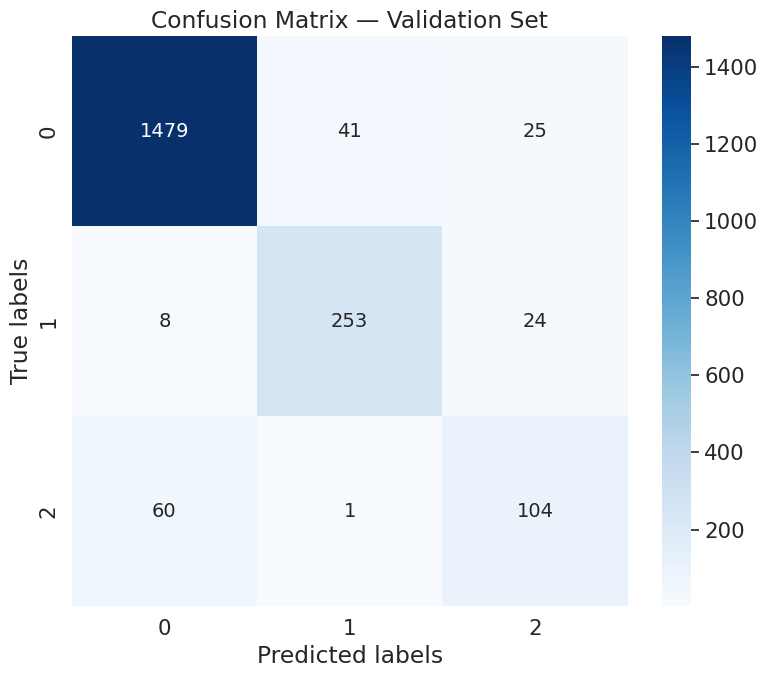

In [40]:
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

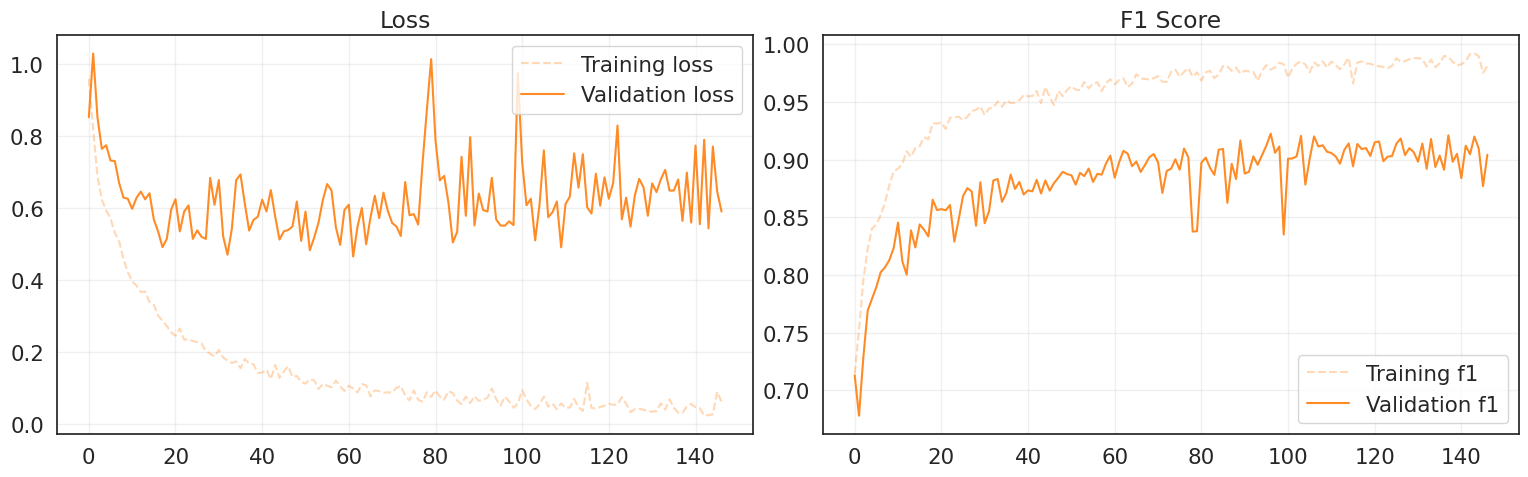

In [41]:
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

# **K-Shuffle-Split Cross Validation**

In [42]:
def k_shuffle_split_cross_validation_pain(
        df, feature_cols, epochs, criterion, device,
        k, n_val_users, n_test_users, batch_size,
        hidden_layers, hidden_size, learning_rate, dropout_rate,
        window_size, stride, rnn_type, bidirectional,
        l1_lambda=0, l2_lambda=0, patience=0,
        evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10,
        seed=42, experiment_name="pain_rnn"):

    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # ---- number of features after preprocessing ----
    #in_features = df_training.shape[1]
    #in_features = df.drop(columns=['sample_index', 'pain_label']).shape[1]
    in_features = len(feature_cols)
    num_classes = df['label'].nunique()


    # ---- initialise model once, reset state every split ----
    model = RecurrentClassifier(
        input_size=in_features,
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(model.state_dict())

    # ------------------ K SPLITS ------------------
    # Iterate through K random splits
    for split_idx in range(k):

        if verbose:
            print(f"\n=== Split {split_idx+1}/{k} ===")

        unique_users = df['sample_index'].unique()
        random.seed(seed + split_idx)
        random.shuffle(unique_users)

        # Calculate the number of users for the training set
        n_train_users = len(unique_users) - n_val_users - n_test_users

        # Split the shuffled user IDs into training, validation, and test sets
        train_users = unique_users[:n_train_users]
        val_users   = unique_users[n_train_users:n_train_users+n_val_users]
        test_users  = unique_users[n_train_users+n_val_users:]

        df_train = df[df['sample_index'].isin(train_users)].copy()
        df_val   = df[df['sample_index'].isin(val_users)].copy()
        df_test  = df[df['sample_index'].isin(test_users)].copy()

        # ------------------ Normalisation ------------------
         # ---- Normalization (only on features) ----
        train_max = df_train[feature_cols].max()
        train_min = df_train[feature_cols].min()
        for d in (df_train, df_val, df_test):
            d[feature_cols] = (d[feature_cols] - train_min) / (train_max - train_min + 1e-8)

        # ---- Build sequences ----
        cols = ['sample_index', 'time'] + feature_cols + ['label']
        X_train, y_train = build_windows(df_train[cols], window_size, stride)
        X_val, y_val     = build_windows(df_val[cols], window_size, stride)
        X_test, y_test   = build_windows(df_test[cols], window_size, stride)

        # ------------------ Loaders ------------------
        train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
        val_ds   = TensorDataset(torch.from_numpy(X_val).float(),   torch.from_numpy(y_val).long())
        test_ds  = TensorDataset(torch.from_numpy(X_test).float(),  torch.from_numpy(y_test).long())

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

        # ---- Reset model weights ----
        model.load_state_dict(initial_state)

        # ---- Optimizer ----
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        scaler = torch.amp.GradScaler(enabled=(device.type=='cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # ---- Fit one split ----
        model, history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=f"{experiment_name}/split_{split_idx}"
        )

        # ---- Store results ----
        fold_losses[f"split_{split_idx}"] = history['val_loss']
        fold_metrics[f"split_{split_idx}"] = history['val_f1']
        best_scores[f"split_{split_idx}"] = max(history['val_f1'])

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores if k.startswith("split_")])
    best_scores["std"]  = np.std([best_scores[k] for k in best_scores if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    #print(f"\nFinal Result: F1 = {best_scores['mean']:.4f} ± {best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores


In [43]:
losses, metrics, best_scores = k_shuffle_split_cross_validation_pain(
    df=df_training,
    feature_cols=feature_cols,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name="pain_gru_cv",
    n_val_users=N_VAL_USERS,
    n_test_users=N_TEST_USERS,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)


=== Split 1/2 ===
Training 400 epochs...
Epoch   1/400 | Train: Loss=0.9704, F1 Score=0.6895 | Val: Loss=0.8880, F1 Score=0.7119
Epoch  10/400 | Train: Loss=0.3913, F1 Score=0.8970 | Val: Loss=0.8450, F1 Score=0.8299
Epoch  20/400 | Train: Loss=0.2189, F1 Score=0.9356 | Val: Loss=0.7353, F1 Score=0.8926
Epoch  30/400 | Train: Loss=0.1549, F1 Score=0.9536 | Val: Loss=0.8890, F1 Score=0.8483
Epoch  40/400 | Train: Loss=0.1262, F1 Score=0.9588 | Val: Loss=0.7306, F1 Score=0.8581
Epoch  50/400 | Train: Loss=0.0953, F1 Score=0.9684 | Val: Loss=0.8989, F1 Score=0.8903
Epoch  60/400 | Train: Loss=0.0816, F1 Score=0.9729 | Val: Loss=0.9765, F1 Score=0.8740
Epoch  70/400 | Train: Loss=0.0689, F1 Score=0.9766 | Val: Loss=1.1166, F1 Score=0.8697
Epoch  80/400 | Train: Loss=0.0817, F1 Score=0.9763 | Val: Loss=1.0553, F1 Score=0.8688
Epoch  90/400 | Train: Loss=0.0448, F1 Score=0.9849 | Val: Loss=1.0718, F1 Score=0.8864
Epoch 100/400 | Train: Loss=0.0611, F1 Score=0.9800 | Val: Loss=1.2264, F1 Sco

In [44]:
def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame
        param_grid: Dict of parameters to test,
        fixed_params: Dict of fixed hyperparameters
        cv_params: Dict of CV settings
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """

    required_params = {
        "feature_cols",
        "epochs",
        "criterion",
        "device",
        "k",
        "n_val_users",
        "n_test_users",
        "batch_size",
        "hidden_layers",
        "hidden_size",
        "learning_rate",
        "dropout_rate",
        "window_size",
        "stride",
        "rnn_type",
        "bidirectional",
        "l1_lambda",
        "l2_lambda",
        "patience",
        "seed",
        "verbose",
    }

    all_possible_params = set(fixed_params.keys()) | set(param_grid.keys()) | set(cv_params.keys())
    missing = required_params - all_possible_params
    if len(missing) > 0:
        raise ValueError(
            "\n[ERROR] Mancano parametri necessari per la cross-validation:\n"
            + "\n".join([f"  - {m}" for m in missing])
            + "\nAggiungili in fixed_params o cv_params."
        )

    # Parametri forniti da fixed_params, grid search e cv_params
    all_possible_params = set(fixed_params.keys()) | set(param_grid.keys()) | set(cv_params.keys())

    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_pain(
            df=df,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            all_best_params = {**fixed_params, **best_config.copy()}
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score, all_best_params


In [45]:
param_grid = {
    'rnn_type': ['GRU', 'LSTM'],
}

fixed_params = {
    'window_size': WINDOW_SIZE,
    'stride': STRIDE,
    #'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL,
    'batch_size': BATCH_SIZE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'learning_rate': LEARNING_RATE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'n_val_users': N_VAL_USERS,
    'n_test_users': N_TEST_USERS,
    'patience': PATIENCE,
    'verbose': VERBOSE,
    'seed': SEED,
    'feature_cols': feature_cols,
}

# Execute search
results, best_config, best_score, all_best_params = grid_search_cv_rnn(
    df=df_training,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


Configuration 1/2:
  rnn_type: GRU

=== Split 1/2 ===
Training 400 epochs...
Epoch   1/400 | Train: Loss=0.9657, F1 Score=0.7102 | Val: Loss=0.8808, F1 Score=0.7382
Epoch  10/400 | Train: Loss=0.3796, F1 Score=0.8924 | Val: Loss=0.6557, F1 Score=0.8585
Epoch  20/400 | Train: Loss=0.2536, F1 Score=0.9265 | Val: Loss=0.7493, F1 Score=0.8550
Epoch  30/400 | Train: Loss=0.3335, F1 Score=0.9078 | Val: Loss=0.6667, F1 Score=0.8582
Epoch  40/400 | Train: Loss=0.1389, F1 Score=0.9565 | Val: Loss=0.8425, F1 Score=0.8636
Epoch  50/400 | Train: Loss=0.1098, F1 Score=0.9633 | Val: Loss=0.7717, F1 Score=0.8786
Epoch  60/400 | Train: Loss=0.0915, F1 Score=0.9683 | Val: Loss=0.8012, F1 Score=0.8840
Epoch  70/400 | Train: Loss=0.0615, F1 Score=0.9804 | Val: Loss=0.8245, F1 Score=0.8828
Epoch  80/400 | Train: Loss=0.0494, F1 Score=0.9826 | Val: Loss=0.8448, F1 Score=0.9102
Epoch  90/400 | Train: Loss=0.0490, F1 Score=0.9829 | Val: Loss=0.8865, F1 Score=0.8949
Epoch 100/400 | Train: Loss=0.0426, F1 Sco

In [46]:
print(all_best_params)

{'window_size': 20, 'stride': 10, 'bidirectional': True, 'batch_size': 64, 'hidden_layers': 1, 'hidden_size': 128, 'learning_rate': 0.0005, 'dropout_rate': 0.4, 'l1_lambda': 0.0, 'l2_lambda': 0.001, 'rnn_type': 'LSTM'}


# **FINAL TRAINING**

In [47]:
def fit_final(model, train_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, writer=None, verbose=10, experiment_name="", learning_rate=1e-3):
    """
    Train the neural network model on the full dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [],
        'train_f1': [],
    }

    print(f"Training {epochs} epochs...")

    # ---- Optimizer ----
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

    scaler = torch.amp.GradScaler(enabled=(device.type=='cuda'))

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['train_f1'].append(train_f1)

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | ")

        # Close TensorBoard writer
        if writer is not None:
            writer.close()

    return model, training_history

In [48]:
rnn_final = RecurrentClassifier(
    input_size=len(feature_cols), # Pass the number of features
    hidden_size=all_best_params.get("hidden_size", HIDDEN_SIZE),
    num_layers=all_best_params.get("hidden_layers", HIDDEN_LAYERS),
    num_classes=num_classes,
    dropout_rate=all_best_params.get("dropout_rate", DROPOUT_RATE),
    bidirectional=all_best_params.get("bidirectional", BIDIRECTIONAL),
    rnn_type=all_best_params.get("rnn_type", RNN_TYPE)
    ).to(device)

In [49]:
batch_size = all_best_params.get("batch_size", BATCH_SIZE)
final_train_loader = make_loader(df_training,batch_size, True, False)

In [52]:
%%time
BEST_EPOCHS_FROM_OUTPUT = 150
EXPERIMENT_NAME = "Last_model.pth"

# Train model and track training history
final_model, training_history = fit_final(
    model=rnn_final,
    train_loader=train_loader,
    epochs=BEST_EPOCHS_FROM_OUTPUT, # all_best_params.get("epochs", EPOCHS), Hardcoded from the output of the grid search
    criterion=criterion,
    optimizer=optimizer,
    learning_rate=all_best_params.get("learning_rate", LEARNING_RATE),
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=10,
    experiment_name=EXPERIMENT_NAME,
    l1_lambda=all_best_params.get("l1_lambda", L1_LAMBDA),
    l2_lambda=all_best_params.get("l2_lambda", L2_LAMBDA),
    )


Training 150 epochs...
Epoch   1/150 | Train: Loss=0.2501, F1 Score=0.9536 | 
Epoch  10/150 | Train: Loss=0.2161, F1 Score=0.9629 | 
Epoch  20/150 | Train: Loss=0.2042, F1 Score=0.9637 | 
Epoch  30/150 | Train: Loss=0.1954, F1 Score=0.9677 | 
Epoch  40/150 | Train: Loss=0.1804, F1 Score=0.9680 | 
Epoch  50/150 | Train: Loss=0.1761, F1 Score=0.9734 | 
Epoch  60/150 | Train: Loss=0.1681, F1 Score=0.9735 | 
Epoch  70/150 | Train: Loss=0.1499, F1 Score=0.9783 | 
Epoch  80/150 | Train: Loss=0.1654, F1 Score=0.9754 | 
Epoch  90/150 | Train: Loss=0.1378, F1 Score=0.9831 | 
Epoch 100/150 | Train: Loss=0.1357, F1 Score=0.9829 | 
Epoch 110/150 | Train: Loss=0.1417, F1 Score=0.9806 | 
Epoch 120/150 | Train: Loss=0.1342, F1 Score=0.9824 | 
Epoch 130/150 | Train: Loss=0.1282, F1 Score=0.9823 | 
Epoch 140/150 | Train: Loss=0.1250, F1 Score=0.9852 | 
Epoch 150/150 | Train: Loss=0.1490, F1 Score=0.9771 | 
CPU times: user 2min 29s, sys: 42.3 s, total: 3min 11s
Wall time: 3min 12s


#🔗 **Save the model!**

In [53]:
# # Create a local directory
save_dir = "/content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/"
os.makedirs(save_dir, exist_ok=True)

# # File name
MODEL_PATH = os.path.join(save_dir, EXPERIMENT_NAME)

# Ensure the full directory path exists for MODEL_PATH
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

# Store the weights
torch.save(final_model.state_dict(), MODEL_PATH)

print(f"Modello salvato localmente in: {MODEL_PATH}")
!ls -lh "$save_dir"

Modello salvato localmente in: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/Last_model.pth
total 5.0M
-rw------- 1 root root 225K Nov 16 14:40 AE_1.pth
-rw------- 1 root root 1.9M Nov 17 19:51 f1_092_low_067_high.pth
-rw------- 1 root root 1.6M Nov 17 16:34 feat_selects_best.pth
-rw------- 1 root root 622K Nov 17 22:50 Last_model.pth
-rw------- 1 root root 622K Nov 17 22:16 LSTM_80W.pth
drwx------ 2 root root 4.0K Nov 17 10:32 rnn_type_GRU
-rw------- 1 root root  17K Nov 17 14:12 submission.csv
-rw------- 1 root root  17K Nov 17 19:51 submission_feat_selection.csv
-rw------- 1 root root  17K Nov 17 16:36 submission_grid.csv
-rw------- 1 root root  17K Nov 17 22:17 submission_LSTM_80.csv
-rw------- 1 root root  17K Nov 17 22:16 submission_new_classificator.csv


#⚠️ **Kaggle inference**

In [59]:
# # ============================================
# # Set the Architecture of the model loaded
# # ============================================
RNN_TYPE = 'LSTM'
BIDIRECTIONAL = True
HIDDEN_LAYERS = 1
HIDDEN_SIZE = 128
DROPOUT_RATE = 0.4
BATCH_SIZE = 64
WINDOW_SIZE = 20
STRIDE = 10

In [60]:
# # # # Recreate model and load weights

best_model_path = MODEL_PATH # set the path, here we use the best in grid search, stored before
model_for_inference = RecurrentClassifier(
       input_size=len(feature_cols), # here we get from the post processing blocks
       hidden_size=HIDDEN_SIZE,
       num_layers=HIDDEN_LAYERS,
       num_classes=num_classes,
       dropout_rate=DROPOUT_RATE,
       bidirectional=BIDIRECTIONAL,
       rnn_type= RNN_TYPE
   ).to(device)

model_for_inference.load_state_dict(torch.load(best_model_path, map_location=device))
model_for_inference.eval()
print("Model loaded for inference.")


Model loaded for inference.


In [61]:
# Load test
df_test = pd.read_csv(os.path.join(dataset_path, "pirate_pain_test.csv"))

# Ensure the same dtypes as training
for col in joint_cols:
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce').astype('float32')

for col in survey_cols:
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce').astype('int8')

df_test["is_injured"] = (df_test["n_legs"] != "two").astype("int8")


# Align columns to training schema
missing_cols = [c for c in df_train.columns if c not in df_test.columns]
for c in missing_cols:
    df_test[c] = 0

df_test = df_test[df_train.columns]  # same column order

# === Apply correct Min-Max scaling ===
df_test = minmax_scaling(df_test, min_train, max_train)

df_test = df_test.fillna(0.0)


In [62]:
def build_windows_test(df, window=WINDOW_SIZE, stride=STRIDE):

    feature_cols = selected_features

    X_windows = []
    indices = []

    for sid, g in df.groupby("sample_index"):
        g = g.sort_values("time")
        X = g[feature_cols].values.astype("float32")

        padding_len = (window - len(X) % window) % window
        if padding_len > 0:
            X = np.concatenate([X, np.zeros((padding_len, X.shape[1]), dtype="float32")])

        for start in range(0, len(X) - window + 1, stride):
            X_windows.append(X[start:start+window])
            indices.append(sid)

    return np.array(X_windows), np.array(indices)


X_test, test_indices = build_windows_test(df_test)


In [63]:
# === INFERENZA CON SOGLIE PERSONALIZZATE === #

test_ds = TensorDataset(torch.from_numpy(X_test))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []

with torch.no_grad():
    for (xb,) in test_loader:
        xb = xb.to(device)

        logits = model_for_inference(xb)

        # USO DELLE SOGLIE
        preds = threshold_predict(logits).cpu().numpy()

        all_preds.append(preds)

all_preds = np.concatenate(all_preds)

# === MAJORITY VOTE PER SAMPLE === #
pred_df = pd.DataFrame({"sample_index": test_indices, "pred": all_preds})
final_preds = (
    pred_df.groupby("sample_index")["pred"]
    .agg(lambda x: np.bincount(x).argmax())
    .reset_index()
)

inv_label_map = {v: k for k, v in label_mapping.items()}
final_preds["label"] = final_preds["pred"].map(inv_label_map)

submission = final_preds.sort_values("sample_index")[["sample_index", "label"]]

submission_path = "/content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/submission_last_model.csv"
submission.to_csv(submission_path, index=False)

print("Submission saved at:", submission_path)


Submission saved at: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/submission_last_model.csv
